In [1]:
import time
import math
import sympy as sp
import numpy as np
from numpy.polynomial import polynomial as p
import matplotlib.pyplot as plt
from sage.all import *
from sage.stats.distributions.discrete_gaussian_integer import DiscreteGaussianDistributionIntegerSampler
from sage.stats.distributions.discrete_gaussian_polynomial import DiscreteGaussianDistributionPolynomialSampler 
import sys

In [2]:
def balance(x, q):
    return np.array([n if n <= (q-1)/2 else n-q for n in x.flatten()]).reshape(np.shape(x))

In [14]:
class commitmentScheme(object):
    lamb = None
    p = None
    n = None
    k = None 
    m = None
    l = None
    v = None
    N = None
    B = None
    
    def __init__(self, lamb, p, N): #n, k, m):
        self.lamb = lamb
        self.p = p
        # self.n = n 
        # self.k = k 
        # self.m = m
        self.N = N
        
    def gen(self):
        # Set parameters as in BBC+18
        # P = self.n*self.k**2*self.m**2*self.p**2
        # B = P*self.k*self.m*self.n #B = O(PN)
        # Pp = B*P
        r = int(np.ceil(np.log(self.N))) #r = O(log n) or O(log N)? 
        q = sp.nextprime(2**100)  # !!!!!
        # print("P = " + str(P))
        # print("B = " + str(B))
        # print("Pp = " + str(Pp))
        # print("r = " + str(r))
        # print("log2 q = " + str(math.log2(q)))
        
        n = int(np.ceil(np.sqrt(self.N*r*math.log(q, self.p)\
                                /self.lamb*np.log2(self.N*self.lamb*self.p))))
        k = int(np.ceil(self.lamb/np.log2(self.p)))
        m = int(np.ceil(self.N/(n*k)))
        
        # print("n = " + str(n))
        # print("k = " + str(k))
        # print("m = " + str(m))
        
        A1 = np.array([randint(-(q-1)//2, (q-1)//2) for _ in range(r*int(2*r*math.log(q, self.p)))]).reshape(r, int(2*r*math.log(q, self.p))) 
        A2 = np.array([randint(-(q-1)//2, (q-1)//2) for _ in range(r*n)]).reshape(r, n)
        # print("Shapes of matrices A1, A2: " + str(A1.shape) + " " + str(A2.shape))
        return (self.p, q, r, n, k ,m , A1, A2)
    
def commit(msg, r, ck): #r = randomness
    q = ck[1]
    n = ck[3]
    k = ck[4]
    m = ck[5]
    A1 = ck[6]
    A2 = ck[7]
    msg = np.resize(msg, (k, n))
    C = (A1 @ r[0]) % q + (A2 @ msg[0]) % q
    for i in range(k-1):
        C = np.vstack((C, (A1 @ r[i+1]) % q + (A2 @ msg[i+1]) % q))
    return balance(C, q)
        #return C

In [16]:
def commit_test():
    
    #Commitment for k messages msg in (Z_p)^n
    #Can be seen as a commitment for a (nxk)-matrix
    #In the arithmetic circuit protocol we will commit to m (nxk)-matrices 
    
    lamb = 128
    p = 4093
    N = 10000
    # n = int(np.ceil(np.sqrt(N)))
    # k = int(N/n)  # int(np.ceil(lamb/np.log2(p)))
    # m = int(np.ceil(N/(k*n)))
        
    # sigma1 = 48*np.sqrt(k*n)*k*m*p**2
    
    sigma1 = 1000
    
    D = DiscreteGaussianDistributionIntegerSampler(sigma1)
    
    msg = np.random.randint((-p+1)/2, (p-1)/2+1, size = N)
    
    print("Messages: " + str(msg) + " (modulo " + str(p) + ")")
    print("Size of the message: " + str(msg.nbytes / 1000) + " kB")
    
    start_time = time.time()

    cs = commitmentScheme(lamb, p, N)

    ck = cs.gen()
    
    r = np.array([D() for _ in range(ck[4]*int(2*ck[2]*math.log(ck[1], ck[0])))]).reshape(ck[4], int(2*ck[2]*math.log(ck[1], ck[0])))

    com_msg = commit(msg, r, ck)

    end_time = time.time()
    
    print("Size of the message: " + str(msg.nbytes / 1000) + " kB")
    print("Size of the commitment: " + str(com_msg.nbytes / 1000) + " kB")
    
    print("Total execution time: " + str(end_time - start_time) + " seconds")

commit_test()

Messages: [-1441 -1192  2029 ...    35 -1379  1997] (modulo 4093)
Size of the message: 80.0 kB
Size of the message: 80.0 kB
Size of the commitment: 0.88 kB
Total execution time: 0.019742727279663086 seconds


In [35]:
N = 30000 # Number of elements
lamb = 128
p = 4099

msg = np.random.randint((-p+1)//2, (p-1)//2+1, size = N)
cs = commitmentScheme(lamb, p, N)
ck = cs.gen()

nprime = int(2*ck[2]*math.log(ck[1], ck[0]))

randomness = np.array([randint((-p+1)//2, (p-1)//2+1) for _ in range(ck[4]*nprime)]).reshape(ck[4], nprime)

# Commit and prove a single message msg in Z_p^(kxn)

n,k,m = ck[3], ck[4], ck[5]

msg = np.resize(msg, (m,k,n))

def commit_and_prove(msg, randomness, ck):
    
    n, k = ck[3], ck[4]
    
    msg = np.resize(msg, (k,n))  # We assume msg is already resized, but just in case
    
    committed_message = commit(msg, randomness, ck)
    
    A = np.hstack((ck[6], ck[7]))
    S = np.hstack((randomness, msg)).T
    T = committed_message.T
    
    # print(A.shape, S.shape, T.shape)
    
    # ZKP to convince a verifier that a prover knows S such that A@S = T
    
    proof = Proof(lamb, ck[1], A, S, T)
    bit, size = proof.run()
    # proof.print_stats()
    return committed_message, bit, size

randomness = np.array([randint((-p+1)//2, (p-1)//2+1) for _ in range(ck[5]*ck[4]*nprime)]).reshape(ck[5], ck[4], nprime)

# Commits and proves to m messages, each in Z_q^(kxn), with m,k,n chosen by the commitment

def commit_and_prove_all(msg, randomness, ck):
    
    n,k,m = ck[3], ck[4], ck[5]
    msg = np.resize(msg, (m, k, n)) # We assume msg is already resized, but just in case
    
    # Initialize values with first commitment to get correct shape for com_msg
    com_msg, verification, total_size = commit_and_prove(msg[0], randomness[0], ck)
    com_msg = [com_msg]
    
    
    # Commit and prove the rest of the messages
    for i in range(1,m):
        
        com_msg_i, bit, size = commit_and_prove(msg[i], randomness[i], ck)
        
        com_msg = np.append(com_msg, [com_msg_i], axis = 0)
        verification = verification and bit
        total_size += size
    
    # print("Verification: " +  str(verification))
    # print("Number of elements of communication: " + str(total_size))
    
    return com_msg, verification, total_size

commit_and_prove_all(msg, randomness, ck)[1:] # [1:] so it does not show the commitments

(True, 1084200)

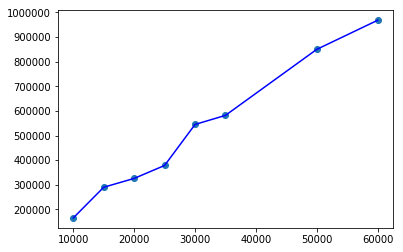

In [43]:
lamb = 128
p = 4099
msg_sizes = [10000,15000,20000,25000,30000,35000,50000,60000]
com_sizes = []
def sublinearity_test():
    for i in range(len(msg_sizes)):
        # Create random message
        msg = np.random.randint((-p+1)//2, (p-1)//2+1, size = msg_sizes[i])

        # Generate commitment key
        cs = commitmentScheme(lamb, p, msg_sizes[i])
        ck = cs.gen()

        # Generate randomness
        nprime = int(2*ck[2]*math.log(ck[1], ck[0]))
        randomness = np.array([randint((-p+1)//2, (p-1)//2+1) for _ in range(ck[5]*ck[4]*nprime)]).reshape(ck[5], ck[4], nprime)

        # Run the proof
        _, bit, communication = commit_and_prove_all(msg, randomness, ck)
        
        # Store communication size
        com_sizes.append(communication)
        
    # Print sizes    
    plt.plot(msg_sizes, com_sizes, 'o', msg_sizes, com_sizes, 'b')
    plt.show()
    

sublinearity_test()

In [5]:
#Balance algorithm
#Given a matrix x with coeffs in [0, q], returns the same matrix with coeffs in [-(q-1)/2, (q-1)/2]
def balance(x, q):
    return np.array([n if n <= (q-1)/2 else n-q for n in x.flatten()]).reshape(np.shape(x))

In [6]:
class Prover:
    
    A = None
    S = None
    T = None
    sigma = None
    Y = None
     
    def __init__(self, lamb, q, A, S, T):
        self.q = q
        self.A = A
        self.S = S
        self.T = T
        self.Y = []
        
        s = np.linalg.norm(S, 2) + 1  # Upper bound on s_1(S)
        
        self.l = S.shape[1]
        self.n = lamb + 2
        assert A.shape[1] == S.shape[0]
        self.v = A.shape[1]
        
        self.rho = 3
        self.sigma = 12/np.log(self.rho)*s*np.sqrt(self.l*self.n)
        self.B = math.sqrt(2*self.v)*self.sigma  # This is somehow known by the verifier
 
        # print("s = " + str(s))
        # print("sigma = " + str(self.sigma))
        # print("B = " + str(self.B))
        
    
    def calculateW(self, n):
        D = DiscreteGaussianDistributionIntegerSampler(self.sigma)
        self.Y = np.array([D() for _ in range(self.v*self.n)]).reshape(self.v,self.n)
        W = np.matmul(self.A, self.Y)
        return W
    
    def calculateZ(self, C):
        self.C = C
        self.Z = self.S @ self.C + self.Y
        return self.Z
    
    def reject(self):
        def Rej(Z, B, sigma, rho):
            u = np.random.random()
            if u > 1/rho * np.exp((-2*Z.flatten().dot(B.flatten()) + np.linalg.norm(B.flatten())**2)/(2*sigma**2)):
                return 0
            else:
                return 1
        return Rej(self.Z, self.S@self.C, self.sigma, self.rho)

In [7]:
class Verifier:
    
    A = None
    T = None
    W = None
    C = None
    
    def __init__(self, A, T):
        self.A = A
        self.T = T
        self.W = []
        self.C = []
        
    def calculateC(self, W):
        self.W = W
        n = W.shape[1]
        l = self.T.shape[1]
        self.C = np.random.randint(2, size=[l,n])
        return self.C
    
    def verify(self, Z, B, q):
        AZ = self.A @ Z
        TC = self.T @ self.C
        return np.array_equal(AZ % q, (TC + self.W) % q) and np.all(np.linalg.norm(Z, np.inf, axis=0) <= B)
        

In [41]:
class Proof:
    
    prover = None
    verifier = None
    
    W = None
    C = None
    Z = None
    
    bit = None
    num_aborts = None
    running_time = None
    proof_size = None
    
    
    def __init__(self, lamb, q, A, S, T):
        self.prover = Prover(lamb, q, A, S, T)
        self.verifier = Verifier(A, T)

    def run(self):
        abort = True
        self.num_aborts = 0

        # Protocol starts

        start_time = time.time()

        self.proof_size = 0

        self.W = self.prover.calculateW(self.prover.n)
        
        self.proof_size += self.W.size  # self.W.nbytes

        while abort:

            self.C = self.verifier.calculateC(self.W)

            self.Z = self.prover.calculateZ(self.C)

            # self.proof_size += self.Z.size #  + self.C.size
            
            # self.proof_size += self.Z.nbytes + self.C.nbytes

            #Rejection sampling

            abort = self.prover.reject()
            self.num_aborts += abort

        #Verification

        self.proof_size += self.Z.size
        
        B = self.prover.B  # ???

        self.bit = self.verifier.verify(self.Z, B, self.prover.q)

        end_time = time.time()
        
        self.running_time = end_time - start_time
        
        return self.bit, self.proof_size
        
    def print_stats(self):

        print("Verification: " +  str(self.bit))
        print("Times aborted: " + str(self.num_aborts))
        print("Total execution time: " + str(self.running_time) + " seconds")
        print("Number of elements of the witness: " + str(self.prover.S.size))
        print("Number of elements of communication: " + str(self.proof_size) + " (modulo " + str(self.prover.q) + ")")
        # print("Size of the witness: " + str(self.prover.S.nbytes / 1000) + " kB")
        # print("Size of the proof: " + str(self.proof_size / 1000) + " kB")
